In [37]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from bayes_opt import BayesianOptimization
import time
import warnings
warnings.filterwarnings('ignore')

In [38]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    """
    Transforming the categorical features into new features with one hot encoding to ensure that there's no 
    hierarchy between the different categories in each column.
    """
    onehotencoder = OneHotEncoder()
    for col in labelCols:
        data[col] = data[col].astype(str)
        X = onehotencoder.fit_transform(data[col].values.reshape(-1, 1)).toarray()
        dfOneHot = pd.DataFrame(X) 
        listValues = list(data[col].unique())
        listValues.remove("nan")
        for i in range(len(listValues)):
            for column in dfOneHot:
                if dfOneHot[column].sum() == (data[col] == listValues[i]).sum():
                    data[col + "_" + str(listValues[i])] = dfOneHot[column]
        data = data.drop(columns=[col])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    for col in numericalCols:
        if col == "Age":
            data[col] = data[col].fillna(data[col].mean())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
        data[col] = (data[col] - data[col].mean())/(data[col].std())
    
    return data


[0.18723247 0.3205003  0.42918079 0.5311294  0.62715679 0.71217121
 0.76835846 0.8221937  0.86684426 0.90191784 0.92687558 0.94388589
 0.95571319 0.9667193  0.97649804 0.98276294 0.98856729 0.99275188
 0.99467812 0.9960491  0.99738318 0.99836153 0.99917469 0.99992833
 1.         1.        ]


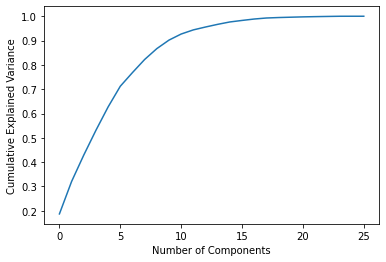

In [39]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)

#Conducting PCA to see if we can reduce the number of dimensions in the dataset. 
y = data["Transported"]
X = data.drop(columns=["Transported"])
pca = PCA()
XPca = pca.fit_transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

"""
After just 13 principal components more than 95% of the explained variance is covered by the newly
transformed XPca dataset according to the output and plot generated below. We'll still try including 
the further principal components in the XPca dataset to see exactly how many dimensions are required 
in our training dataset to produce the greatest accuracy.
"""
print(np.cumsum(pca.explained_variance_ratio_))

In [40]:
#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateKNNModel(k, weight, metric):
    weights = ['uniform', 'distance']
    metrics = ['euclidean', 'manhattan', 'minkowski']
    return KNeighborsClassifier(n_neighbors = k, weights = weights[weight], metric = metrics[metric])
    
def score(k, weight, metric):
    k = round(k)
    weight = round(weight)
    metric = round(metric)
    
    def generateModel():
        return generateKNNModel(k, weight, metric)
        
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = generateModel()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=kfold)
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'k': k,
            'weight': weight,
            'metric': metric
        })
    return mean_acc

hyperparams = {
    'k': (1, 23),
    'weight': (0, 1),
    'metric': (0, 2)
}
start = time.time()
for dim in range(13, 27):
    X = XPca[:, :dim]
    print("Running Bayesian Optimization on the Training Dataset With " + str(dim) + " Dimensions")
    bo = BayesianOptimization(score, hyperparams, random_state=1)
    bo.maximize(init_points=100, n_iter=10)
    print(str(dim) + " Dimensions Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
    max_score = (0, {})
    print()
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

Running Bayesian Optimization on the Training Dataset With 13 Dimensions
|   iter    |  target   |     k     |  metric   |  weight   |
-------------------------------------------------------------
| 1         | 0.784     | 10.17     | 1.441     | 0.0001144 |
| 2         | 0.7805    | 7.651     | 0.2935    | 0.09234   |
| 3         | 0.7764    | 5.098     | 0.6911    | 0.3968    |
| 4         | 0.7786    | 12.85     | 0.8384    | 0.6852    |
| 5         | 0.7733    | 5.498     | 1.756     | 0.02739   |
| 6         | 0.778     | 15.75     | 0.8346    | 0.5587    |
| 7         | 0.7544    | 4.089     | 0.3962    | 0.8007    |
| 8         | 0.7803    | 22.3      | 0.6268    | 0.6923    |
| 9         | 0.7903    | 20.28     | 1.789     | 0.08504   |
| 10        | 0.7301    | 1.859     | 0.3397    | 0.8781    |
| 11        | 0.7585    | 3.164     | 0.8422    | 0.9579    |
| 12        | 0.7849    | 12.73     | 1.384     | 0.3155    |
| 13        | 0.7882    | 16.1      | 1.669     | 0.01829  

| 80        | 0.7773    | 14.06     | 0.8674    | 0.8074    |
| 81        | 0.7718    | 7.935     | 1.786     | 0.5779    |
| 82        | 0.7658    | 5.048     | 1.576     | 0.612     |
| 83        | 0.7273    | 2.186     | 0.8404    | 0.6791    |
| 84        | 0.7837    | 21.21     | 0.000804  | 0.9768    |
| 85        | 0.7748    | 9.285     | 1.948     | 0.6047    |
| 86        | 0.7797    | 19.23     | 1.149     | 0.6281    |
| 87        | 0.7743    | 7.283     | 1.174     | 0.75      |
| 88        | 0.783     | 19.88     | 1.51      | 0.6981    |
| 89        | 0.7802    | 20.02     | 0.6454    | 0.6708    |
| 90        | 0.784     | 10.92     | 0.7642    | 0.4108    |
| 91        | 0.7767    | 9.833     | 0.6348    | 0.6219    |
| 92        | 0.7731    | 10.47     | 1.948     | 0.6778    |
| 93        | 0.7764    | 5.369     | 0.8534    | 0.3433    |
| 94        | 0.7812    | 18.55     | 1.76      | 0.9038    |
| 95        | 0.7868    | 15.58     | 0.5404    | 0.2524    |
| 96    

| 47        | 0.7798    | 20.0      | 1.494     | 0.5562    |
| 48        | 0.7649    | 4.002     | 0.1198    | 0.1213    |
| 49        | 0.7448    | 1.98      | 0.215     | 0.2257    |
| 50        | 0.7865    | 16.69     | 1.119     | 0.01256   |
| 51        | 0.7575    | 2.583     | 1.935     | 0.5681    |
| 52        | 0.7689    | 5.472     | 0.5047    | 0.7438    |
| 53        | 0.7689    | 5.299     | 1.163     | 0.97      |
| 54        | 0.791     | 19.63     | 0.4797    | 0.4938    |
| 55        | 0.7889    | 14.64     | 1.658     | 0.1568    |
| 56        | 0.742     | 1.409     | 0.14      | 0.4863    |
| 57        | 0.7852    | 14.34     | 1.138     | 0.3174    |
| 58        | 0.7907    | 22.75     | 1.159     | 0.3801    |
| 59        | 0.7804    | 13.12     | 1.491     | 0.6692    |
| 60        | 0.7789    | 6.828     | 0.1327    | 0.3701    |
| 61        | 0.781     | 14.85     | 0.4203    | 0.7528    |
| 62        | 0.7293    | 2.464     | 0.5206    | 0.8048    |
| 63    

| 14        | 0.7821    | 17.5      | 1.978     | 0.7482    |
| 15        | 0.7792    | 7.17      | 1.579     | 0.1032    |
| 16        | 0.7835    | 10.85     | 1.817     | 0.2936    |
| 17        | 0.7792    | 7.331     | 0.2601    | 0.01937   |
| 18        | 0.7896    | 15.93     | 0.4233    | 0.2655    |
| 19        | 0.7788    | 11.81     | 0.1067    | 0.5741    |
| 20        | 0.7587    | 4.228     | 1.179     | 0.6998    |
| 21        | 0.759     | 3.251     | 0.8281    | 0.6944    |
| 22        | 0.7759    | 10.11     | 0.09991   | 0.5359    |
| 23        | 0.783     | 15.6      | 1.03      | 0.9446    |
| 24        | 0.7863    | 13.9      | 1.807     | 0.1375    |
| 25        | 0.766     | 4.064     | 1.615     | 0.3977    |
| 26        | 0.776     | 4.638     | 1.855     | 0.3478    |
| 27        | 0.7827    | 17.52     | 1.452     | 0.8833    |
| 28        | 0.7905    | 14.72     | 1.502     | 0.3489    |
| 29        | 0.7792    | 6.938     | 1.792     | 0.4281    |
| 30    

| 95        | 0.7875    | 15.58     | 0.5404    | 0.2524    |
| 96        | 0.782     | 19.81     | 1.055     | 0.8022    |
| 97        | 0.7798    | 13.59     | 1.466     | 0.519     |
| 98        | 0.787     | 17.96     | 1.138     | 0.4657    |
| 99        | 0.7863    | 8.539     | 0.1364    | 0.3779    |
| 100       | 0.7661    | 2.752     | 1.966     | 0.1816    |
| 101       | 0.7924    | 18.73     | 0.0       | 0.0       |
| 102       | 0.7894    | 17.22     | 0.03838   | 0.00229   |
| 103       | 0.783     | 18.93     | 0.0235    | 0.97      |
| 104       | 0.7951    | 23.0      | 0.0       | 0.0       |
| 105       | 0.7916    | 19.89     | 0.0       | 0.0       |
| 106       | 0.7951    | 23.0      | 2.0       | 0.0       |
| 107       | 0.7912    | 23.0      | 0.8093    | 0.0       |
| 108       | 0.7838    | 23.0      | 1.992     | 0.9809    |
| 109       | 0.7924    | 18.71     | 2.0       | 0.0       |
| 110       | 0.7838    | 20.74     | 2.0       | 1.0       |
15 Dimen

| 62        | 0.724     | 2.464     | 0.5206    | 0.8048    |
| 63        | 0.7672    | 5.256     | 1.279     | 0.5247    |
| 64        | 0.7894    | 21.35     | 0.5266    | 0.06596   |
| 65        | 0.7803    | 17.17     | 1.544     | 0.9078    |
| 66        | 0.7933    | 21.5      | 0.0279    | 0.2344    |
| 67        | 0.7813    | 14.57     | 1.898     | 0.9502    |
| 68        | 0.78      | 13.25     | 1.831     | 0.6416    |
| 69        | 0.7783    | 9.58      | 0.972     | 0.6043    |
| 70        | 0.78      | 13.09     | 1.852     | 0.9187    |
| 71        | 0.785     | 9.687     | 1.927     | 0.174     |
| 72        | 0.7521    | 3.779     | 0.2702    | 0.5057    |
| 73        | 0.7343    | 1.474     | 1.896     | 0.8271    |
| 74        | 0.7343    | 1.33      | 0.3524    | 0.3321    |
| 75        | 0.7627    | 3.882     | 1.619     | 0.3447    |
| 76        | 0.7803    | 21.68     | 1.164     | 0.8788    |
| 77        | 0.7905    | 19.58     | 1.811     | 0.4599    |
| 78    

| 29        | 0.779     | 6.938     | 1.792     | 0.4281    |
| 30        | 0.7804    | 22.23     | 1.327     | 0.6217    |
| 31        | 0.7631    | 3.524     | 1.899     | 0.4499    |
| 32        | 0.7828    | 13.72     | 0.8163    | 0.237     |
| 33        | 0.7905    | 20.87     | 1.147     | 0.00287   |
| 34        | 0.7797    | 14.58     | 0.6533    | 0.5271    |
| 35        | 0.7817    | 20.49     | 0.7145    | 0.9085    |
| 36        | 0.7827    | 14.71     | 0.03164   | 0.9294    |
| 37        | 0.7886    | 16.2      | 1.995     | 0.1723    |
| 38        | 0.7529    | 4.017     | 1.865     | 0.6968    |
| 39        | 0.7276    | 2.452     | 1.511     | 0.7539    |
| 40        | 0.7905    | 21.31     | 1.423     | 0.1243    |
| 41        | 0.7331    | 1.437     | 0.05242   | 0.02831   |
| 42        | 0.7673    | 6.417     | 1.72      | 0.5388    |
| 43        | 0.7887    | 13.16     | 1.684     | 0.1242    |
| 44        | 0.7735    | 7.142     | 1.172     | 0.9696    |
| 45    

| 110       | 0.7827    | 16.87     | 0.0       | 1.0       |
17 Dimensions Best Accuracy: 0.795581 using {'k': 23, 'weight': 0, 'metric': 0}

Running Bayesian Optimization on the Training Dataset With 18 Dimensions
|   iter    |  target   |     k     |  metric   |  weight   |
-------------------------------------------------------------
| 1         | 0.7824    | 10.17     | 1.441     | 0.0001144 |
| 2         | 0.7792    | 7.651     | 0.2935    | 0.09234   |
| 3         | 0.7732    | 5.098     | 0.6911    | 0.3968    |
| 4         | 0.7788    | 12.85     | 0.8384    | 0.6852    |
| 5         | 0.7736    | 5.498     | 1.756     | 0.02739   |
| 6         | 0.7806    | 15.75     | 0.8346    | 0.5587    |
| 7         | 0.7542    | 4.089     | 0.3962    | 0.8007    |
| 8         | 0.7798    | 22.3      | 0.6268    | 0.6923    |
| 9         | 0.7926    | 20.28     | 1.789     | 0.08504   |
| 10        | 0.7306    | 1.859     | 0.3397    | 0.8781    |
| 11        | 0.7535    | 3.164     | 0.

| 77        | 0.7926    | 19.58     | 1.811     | 0.4599    |
| 78        | 0.7865    | 13.02     | 1.597     | 0.2857    |
| 79        | 0.7824    | 11.79     | 1.198     | 0.01553   |
| 80        | 0.7798    | 14.06     | 0.8674    | 0.8074    |
| 81        | 0.7753    | 7.935     | 1.786     | 0.5779    |
| 82        | 0.769     | 5.048     | 1.576     | 0.612     |
| 83        | 0.7244    | 2.186     | 0.8404    | 0.6791    |
| 84        | 0.7857    | 21.21     | 0.000804  | 0.9768    |
| 85        | 0.7786    | 9.285     | 1.948     | 0.6047    |
| 86        | 0.7795    | 19.23     | 1.149     | 0.6281    |
| 87        | 0.7735    | 7.283     | 1.174     | 0.75      |
| 88        | 0.7853    | 19.88     | 1.51      | 0.6981    |
| 89        | 0.7818    | 20.02     | 0.6454    | 0.6708    |
| 90        | 0.7836    | 10.92     | 0.7642    | 0.4108    |
| 91        | 0.7799    | 9.833     | 0.6348    | 0.6219    |
| 92        | 0.7774    | 10.47     | 1.948     | 0.6778    |
| 93    

| 44        | 0.7736    | 7.142     | 1.172     | 0.9696    |
| 45        | 0.7826    | 13.34     | 0.03729   | 0.8006    |
| 46        | 0.773     | 6.125     | 1.614     | 0.3879    |
| 47        | 0.7813    | 20.0      | 1.494     | 0.5562    |
| 48        | 0.7636    | 4.002     | 0.1198    | 0.1213    |
| 49        | 0.7429    | 1.98      | 0.215     | 0.2257    |
| 50        | 0.7874    | 16.69     | 1.119     | 0.01256   |
| 51        | 0.753     | 2.583     | 1.935     | 0.5681    |
| 52        | 0.7666    | 5.472     | 0.5047    | 0.7438    |
| 53        | 0.7666    | 5.299     | 1.163     | 0.97      |
| 54        | 0.7935    | 19.63     | 0.4797    | 0.4938    |
| 55        | 0.7895    | 14.64     | 1.658     | 0.1568    |
| 56        | 0.7353    | 1.409     | 0.14      | 0.4863    |
| 57        | 0.7847    | 14.34     | 1.138     | 0.3174    |
| 58        | 0.7914    | 22.75     | 1.159     | 0.3801    |
| 59        | 0.779     | 13.12     | 1.491     | 0.6692    |
| 60    

| 11        | 0.7526    | 3.164     | 0.8422    | 0.9579    |
| 12        | 0.7847    | 12.73     | 1.384     | 0.3155    |
| 13        | 0.7888    | 16.1      | 1.669     | 0.01829   |
| 14        | 0.7855    | 17.5      | 1.978     | 0.7482    |
| 15        | 0.7803    | 7.17      | 1.579     | 0.1032    |
| 16        | 0.7858    | 10.85     | 1.817     | 0.2936    |
| 17        | 0.7803    | 7.331     | 0.2601    | 0.01937   |
| 18        | 0.7888    | 15.93     | 0.4233    | 0.2655    |
| 19        | 0.7815    | 11.81     | 0.1067    | 0.5741    |
| 20        | 0.7521    | 4.228     | 1.179     | 0.6998    |
| 21        | 0.7526    | 3.251     | 0.8281    | 0.6944    |
| 22        | 0.7784    | 10.11     | 0.09991   | 0.5359    |
| 23        | 0.7806    | 15.6      | 1.03      | 0.9446    |
| 24        | 0.7866    | 13.9      | 1.807     | 0.1375    |
| 25        | 0.765     | 4.064     | 1.615     | 0.3977    |
| 26        | 0.7737    | 4.638     | 1.855     | 0.3478    |
| 27    

| 92        | 0.7784    | 10.47     | 1.948     | 0.6778    |
| 93        | 0.7729    | 5.369     | 0.8534    | 0.3433    |
| 94        | 0.7857    | 18.55     | 1.76      | 0.9038    |
| 95        | 0.7864    | 15.58     | 0.5404    | 0.2524    |
| 96        | 0.7818    | 19.81     | 1.055     | 0.8022    |
| 97        | 0.7795    | 13.59     | 1.466     | 0.519     |
| 98        | 0.7855    | 17.96     | 1.138     | 0.4657    |
| 99        | 0.7861    | 8.539     | 0.1364    | 0.3779    |
| 100       | 0.7565    | 2.752     | 1.966     | 0.1816    |
| 101       | 0.7897    | 18.89     | 0.0       | 0.0       |
| 102       | 0.7857    | 19.29     | 0.00383   | 0.9849    |
| 103       | 0.788     | 19.84     | 2.0       | 1.0       |
| 104       | 0.7934    | 19.87     | 0.05387   | 0.1204    |
| 105       | 0.7936    | 23.0      | 0.0       | 0.0       |
| 106       | 0.7936    | 23.0      | 2.0       | 0.0       |
| 107       | 0.7895    | 17.12     | 0.01091   | 0.1508    |
| 108   

| 59        | 0.7789    | 13.12     | 1.491     | 0.6692    |
| 60        | 0.7806    | 6.828     | 0.1327    | 0.3701    |
| 61        | 0.7837    | 14.85     | 0.4203    | 0.7528    |
| 62        | 0.7233    | 2.464     | 0.5206    | 0.8048    |
| 63        | 0.7653    | 5.256     | 1.279     | 0.5247    |
| 64        | 0.7894    | 21.35     | 0.5266    | 0.06596   |
| 65        | 0.7837    | 17.17     | 1.544     | 0.9078    |
| 66        | 0.7927    | 21.5      | 0.0279    | 0.2344    |
| 67        | 0.7837    | 14.57     | 1.898     | 0.9502    |
| 68        | 0.7818    | 13.25     | 1.831     | 0.6416    |
| 69        | 0.7784    | 9.58      | 0.972     | 0.6043    |
| 70        | 0.7818    | 13.09     | 1.852     | 0.9187    |
| 71        | 0.7828    | 9.687     | 1.927     | 0.174     |
| 72        | 0.7546    | 3.779     | 0.2702    | 0.5057    |
| 73        | 0.7356    | 1.474     | 1.896     | 0.8271    |
| 74        | 0.7356    | 1.33      | 0.3524    | 0.3321    |
| 75    

| 26        | 0.7735    | 4.638     | 1.855     | 0.3478    |
| 27        | 0.7801    | 17.52     | 1.452     | 0.8833    |
| 28        | 0.7873    | 14.72     | 1.502     | 0.3489    |
| 29        | 0.7797    | 6.938     | 1.792     | 0.4281    |
| 30        | 0.7803    | 22.23     | 1.327     | 0.6217    |
| 31        | 0.7645    | 3.524     | 1.899     | 0.4499    |
| 32        | 0.7835    | 13.72     | 0.8163    | 0.237     |
| 33        | 0.7882    | 20.87     | 1.147     | 0.00287   |
| 34        | 0.7788    | 14.58     | 0.6533    | 0.5271    |
| 35        | 0.7811    | 20.49     | 0.7145    | 0.9085    |
| 36        | 0.7837    | 14.71     | 0.03164   | 0.9294    |
| 37        | 0.7879    | 16.2      | 1.995     | 0.1723    |
| 38        | 0.7551    | 4.017     | 1.865     | 0.6968    |
| 39        | 0.7297    | 2.452     | 1.511     | 0.7539    |
| 40        | 0.7882    | 21.31     | 1.423     | 0.1243    |
| 41        | 0.7353    | 1.437     | 0.05242   | 0.02831   |
| 42    

| 107       | 0.7939    | 23.0      | 0.0       | 0.0       |
| 108       | 0.7887    | 18.5      | 2.0       | 0.0       |
| 109       | 0.7858    | 23.0      | 2.0       | 1.0       |
| 110       | 0.7806    | 11.94     | 1.957     | 0.8285    |
22 Dimensions Best Accuracy: 0.793855 using {'k': 23, 'weight': 0, 'metric': 2}

Running Bayesian Optimization on the Training Dataset With 23 Dimensions
|   iter    |  target   |     k     |  metric   |  weight   |
-------------------------------------------------------------
| 1         | 0.7819    | 10.17     | 1.441     | 0.0001144 |
| 2         | 0.7803    | 7.651     | 0.2935    | 0.09234   |
| 3         | 0.7735    | 5.098     | 0.6911    | 0.3968    |
| 4         | 0.7784    | 12.85     | 0.8384    | 0.6852    |
| 5         | 0.7737    | 5.498     | 1.756     | 0.02739   |
| 6         | 0.7802    | 15.75     | 0.8346    | 0.5587    |
| 7         | 0.755     | 4.089     | 0.3962    | 0.8007    |
| 8         | 0.7803    | 22.3      | 0.

| 74        | 0.7346    | 1.33      | 0.3524    | 0.3321    |
| 75        | 0.7651    | 3.882     | 1.619     | 0.3447    |
| 76        | 0.7803    | 21.68     | 1.164     | 0.8788    |
| 77        | 0.7906    | 19.58     | 1.811     | 0.4599    |
| 78        | 0.7881    | 13.02     | 1.597     | 0.2857    |
| 79        | 0.7826    | 11.79     | 1.198     | 0.01553   |
| 80        | 0.7782    | 14.06     | 0.8674    | 0.8074    |
| 81        | 0.7758    | 7.935     | 1.786     | 0.5779    |
| 82        | 0.7687    | 5.048     | 1.576     | 0.612     |
| 83        | 0.7229    | 2.186     | 0.8404    | 0.6791    |
| 84        | 0.787     | 21.21     | 0.000804  | 0.9768    |
| 85        | 0.7792    | 9.285     | 1.948     | 0.6047    |
| 86        | 0.7794    | 19.23     | 1.149     | 0.6281    |
| 87        | 0.7731    | 7.283     | 1.174     | 0.75      |
| 88        | 0.7873    | 19.88     | 1.51      | 0.6981    |
| 89        | 0.7807    | 20.02     | 0.6454    | 0.6708    |
| 90    

| 41        | 0.7348    | 1.437     | 0.05242   | 0.02831   |
| 42        | 0.768     | 6.417     | 1.72      | 0.5388    |
| 43        | 0.7887    | 13.16     | 1.684     | 0.1242    |
| 44        | 0.7727    | 7.142     | 1.172     | 0.9696    |
| 45        | 0.7824    | 13.34     | 0.03729   | 0.8006    |
| 46        | 0.772     | 6.125     | 1.614     | 0.3879    |
| 47        | 0.7806    | 20.0      | 1.494     | 0.5562    |
| 48        | 0.7643    | 4.002     | 0.1198    | 0.1213    |
| 49        | 0.7427    | 1.98      | 0.215     | 0.2257    |
| 50        | 0.7865    | 16.69     | 1.119     | 0.01256   |
| 51        | 0.7521    | 2.583     | 1.935     | 0.5681    |
| 52        | 0.7667    | 5.472     | 0.5047    | 0.7438    |
| 53        | 0.7667    | 5.299     | 1.163     | 0.97      |
| 54        | 0.7931    | 19.63     | 0.4797    | 0.4938    |
| 55        | 0.788     | 14.64     | 1.658     | 0.1568    |
| 56        | 0.7348    | 1.409     | 0.14      | 0.4863    |
| 57    

| 8         | 0.7798    | 22.3      | 0.6268    | 0.6923    |
| 9         | 0.7904    | 20.28     | 1.789     | 0.08504   |
| 10        | 0.7293    | 1.859     | 0.3397    | 0.8781    |
| 11        | 0.7523    | 3.164     | 0.8422    | 0.9579    |
| 12        | 0.7837    | 12.73     | 1.384     | 0.3155    |
| 13        | 0.7882    | 16.1      | 1.669     | 0.01829   |
| 14        | 0.7829    | 17.5      | 1.978     | 0.7482    |
| 15        | 0.7792    | 7.17      | 1.579     | 0.1032    |
| 16        | 0.7853    | 10.85     | 1.817     | 0.2936    |
| 17        | 0.7792    | 7.331     | 0.2601    | 0.01937   |
| 18        | 0.7882    | 15.93     | 0.4233    | 0.2655    |
| 19        | 0.7802    | 11.81     | 0.1067    | 0.5741    |
| 20        | 0.7517    | 4.228     | 1.179     | 0.6998    |
| 21        | 0.7523    | 3.251     | 0.8281    | 0.6944    |
| 22        | 0.7777    | 10.11     | 0.09991   | 0.5359    |
| 23        | 0.7799    | 15.6      | 1.03      | 0.9446    |
| 24    

| 89        | 0.7806    | 20.02     | 0.6454    | 0.6708    |
| 90        | 0.7834    | 10.92     | 0.7642    | 0.4108    |
| 91        | 0.778     | 9.833     | 0.6348    | 0.6219    |
| 92        | 0.7777    | 10.47     | 1.948     | 0.6778    |
| 93        | 0.7728    | 5.369     | 0.8534    | 0.3433    |
| 94        | 0.7837    | 18.55     | 1.76      | 0.9038    |
| 95        | 0.7867    | 15.58     | 0.5404    | 0.2524    |
| 96        | 0.7806    | 19.81     | 1.055     | 0.8022    |
| 97        | 0.7781    | 13.59     | 1.466     | 0.519     |
| 98        | 0.7865    | 17.96     | 1.138     | 0.4657    |
| 99        | 0.7859    | 8.539     | 0.1364    | 0.3779    |
| 100       | 0.7562    | 2.752     | 1.966     | 0.1816    |
| 101       | 0.7902    | 18.6      | 0.0       | 0.0       |
| 102       | 0.7837    | 19.29     | 0.00383   | 0.9849    |
| 103       | 0.7932    | 23.0      | 2.0       | 0.0       |
| 104       | 0.7901    | 17.24     | 0.0       | 0.0       |
| 105   

| 56        | 0.735     | 1.409     | 0.14      | 0.4863    |
| 57        | 0.7824    | 14.34     | 1.138     | 0.3174    |
| 58        | 0.7893    | 22.75     | 1.159     | 0.3801    |
| 59        | 0.7775    | 13.12     | 1.491     | 0.6692    |
| 60        | 0.7792    | 6.828     | 0.1327    | 0.3701    |
| 61        | 0.7836    | 14.85     | 0.4203    | 0.7528    |
| 62        | 0.7232    | 2.464     | 0.5206    | 0.8048    |
| 63        | 0.7669    | 5.256     | 1.279     | 0.5247    |
| 64        | 0.7883    | 21.35     | 0.5266    | 0.06596   |
| 65        | 0.7832    | 17.17     | 1.544     | 0.9078    |
| 66        | 0.7919    | 21.5      | 0.0279    | 0.2344    |
| 67        | 0.7836    | 14.57     | 1.898     | 0.9502    |
| 68        | 0.7819    | 13.25     | 1.831     | 0.6416    |
| 69        | 0.778     | 9.58      | 0.972     | 0.6043    |
| 70        | 0.7819    | 13.09     | 1.852     | 0.9187    |
| 71        | 0.7827    | 9.687     | 1.927     | 0.174     |
| 72    

In [41]:
"""
According to the output generated above, the KNN algorithm displayed the best performance when using the 
first 17 principal compnents of the XPca dataset and when using these hyperparameter values: 
{'k': 23, 'weight': 0, 'metric': 0}.
"""

hyperparams = {'k': 23, 'weight': 0, 'metric': 0}

"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
X = XPca[:, :17]
model = generateKNNModel(hyperparams['k'], hyperparams['weight'], hyperparams['metric'])
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.83      0.81      4315
        True       0.82      0.79      0.81      4378

    accuracy                           0.81      8693
   macro avg       0.81      0.81      0.81      8693
weighted avg       0.81      0.81      0.81      8693



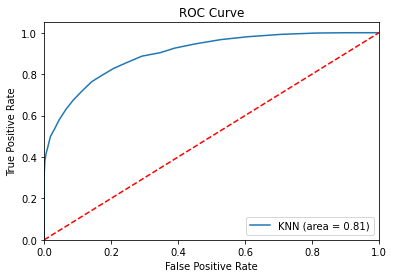

In [42]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)

test_data_pca = pca.fit_transform(test_data)
test_data_pca = test_data_pca[:, :17]

model = generateKNNModel(hyperparams['k'], hyperparams['weight'], hyperparams['metric'])
model.fit(X, y)
y_pred = model.predict(test_data_pca)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission.to_csv('KNearestNeighborsSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.78442 on the test set